# Fraud Detection - in online payments

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import requests
import os

In [91]:
url = "https://raw.githubusercontent.com/AImotion-Bavaria/dpds/main/data/payment_fraud.csv"
downloaded_file = "payment_fraud.csv"

if not(os.path.exists(downloaded_file)):
    response = requests.get(url)
    with open(downloaded_file, "wb") as file:
        file.write(response.content)   
    
data_file = downloaded_file

df = pd.read_csv(downloaded_file)
df.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,paypal,28.204861,0
1,725,1,4.742303,storecredit,0.000000,0
2,845,1,4.921318,creditcard,0.000000,0
3,503,1,4.886641,creditcard,0.000000,0
4,2000,1,5.040929,creditcard,0.000000,0


## Data preprocessing
**paymentMethod** contains strings (`dtype: object` in a data frame) - we need to convert them to numbers first

In [92]:
pd.Categorical(df["paymentMethod"])
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['paymentMethod'] = label_encoder.fit_transform(df['paymentMethod'])
df

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,1,28.204861,0
1,725,1,4.742303,2,0.000000,0
2,845,1,4.921318,0,0.000000,0
3,503,1,4.886641,0,0.000000,0
4,2000,1,5.040929,0,0.000000,0
...,...,...,...,...,...,...
39216,986,1,4.836982,0,0.000000,0
39217,1647,1,4.876771,0,377.930556,0
39218,1591,1,4.742303,0,0.000000,0
39219,237,1,4.921318,0,236.082639,0


Now train a `DecisionTreeClassifier` to predict the label

In [93]:
# Split dataset up into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1), df['label'],
    test_size=0.33, random_state=17)

clf = DecisionTreeClassifier().fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_test))

1.0


What are the most important features?

In [25]:
clf.feature_importances_

array([1., 0., 0., 0., 0.])

Show the distribution of the first feature, `accountAgeDays` for both labels, correct and fraud.

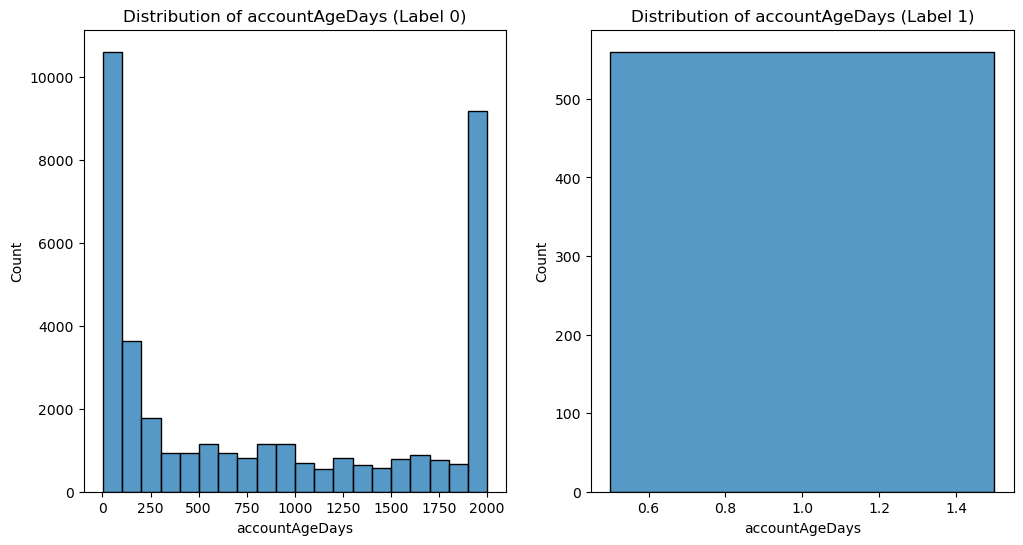

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame by label
label_0_df = df[df['label'] == 0]
label_1_df = df[df['label'] == 1]

# Create subplots for the two distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of 'accountAgeDays' for label 0
sns.histplot(data=label_0_df, x='accountAgeDays', ax=axes[0])
axes[0].set_title('Distribution of accountAgeDays (Label 0)')

# Plot the distribution of 'accountAgeDays' for label 1
sns.histplot(data=label_1_df, x='accountAgeDays', ax=axes[1])
axes[1].set_title('Distribution of accountAgeDays (Label 1)')

# Display the plot
plt.show()


In [101]:
features = df.columns.to_list()
features.remove("label")

['accountAgeDays',
 'numItems',
 'localTime',
 'paymentMethod',
 'paymentMethodAgeDays']

[Text(0.5, 0.75, 'accountAgeDays <= 1.5\ngini = 0.028\nsamples = 26278\nvalue = [25908, 370]\nclass = Normal'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 370\nvalue = [0, 370]\nclass = Fraud'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 25908\nvalue = [25908, 0]\nclass = Normal')]

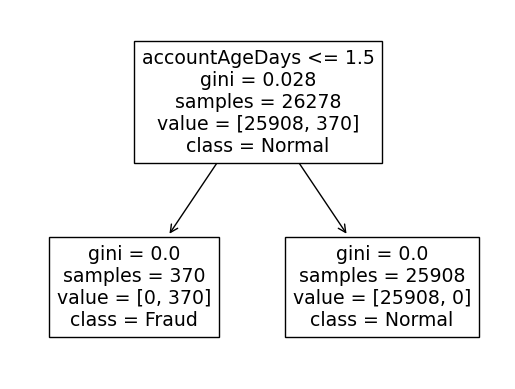

In [103]:
# Show the decision tree that we actually trained
from sklearn import tree
tree.plot_tree(clf, feature_names=features, class_names=["Normal", "Fraud"])

## Just anomaly detection on the non-fraud cases 

For testing, we keep a lot of the non-fraudulent test cases

In [76]:
# Split dataset up into train and test sets

# just the non-fraud cases 
normal_df = df[df['label'] == 0]
fraud_df = df[df['label'] == 1]

# how many fraud cases do we have? 
print(normal_df.size)
print(fraud_df.size)

# sample as many cases as frauds for a test set (or twice as many )
print(normal_df.shape)
test_normals = normal_df.sample(n = fraud_df.shape[0], random_state=42)
normal_df = normal_df.drop(test_normals.index)
print(test_normals.shape)
print(normal_df.shape)

test_df = pd.concat([fraud_df, test_normals])


231966
3360
(38661, 6)
(560, 6)
(38101, 6)


In [81]:
print(normal_df.head())
print(normal_df.columns)

X_train = normal_df.drop("label", axis=1).to_numpy()
X_test = test_df.drop("label", axis=1).to_numpy()

print(X_train.shape)
y_test = test_df["label"]
print(y_test)

   accountAgeDays  numItems  localTime  paymentMethod  paymentMethodAgeDays  \
0              29         1   4.745402              1             28.204861   
1             725         1   4.742303              2              0.000000   
2             845         1   4.921318              0              0.000000   
3             503         1   4.886641              0              0.000000   
4            2000         1   5.040929              0              0.000000   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  
Index(['accountAgeDays', 'numItems', 'localTime', 'paymentMethod',
       'paymentMethodAgeDays', 'label'],
      dtype='object')
(38101, 5)
109      1
243      1
280      1
362      1
420      1
        ..
27044    0
21591    0
13554    0
29130    0
2899     0
Name: label, Length: 1120, dtype: int64


In [86]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance	import EllipticEnvelope
from sklearn.metrics import accuracy_score

for model in [EllipticEnvelope, IsolationForest, OneClassSVM]:
    clf = model().fit(X_train)
    # Convert IsolationForest predictions from -1 and 1 to 0 and 1 respectively
    predicted_labels = clf.predict(X_test)
    #print(predicted_labels)
    predicted_labels = [0 if label == 1 else 1 for label in predicted_labels]
    print(model)
    print(predicted_labels)
    # Calculate accuracy
    accuracy = accuracy_score(test_df["label"], predicted_labels)

    # Print the accuracy
    print("Accuracy:", accuracy)


<class 'sklearn.covariance._elliptic_envelope.EllipticEnvelope'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [84]:


# Assuming you have the IsolationForest predictions stored in 'predicted_labels'
# and the actual labels in 'actual_labels'




[-1  1  1 ...  1  1  1]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 

In [65]:
print(predictions)

[0 1 1 ... 1 1 1]


In [58]:
print(clf)

IsolationForest()


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1), df['label'],
    test_size=0.33, random_state=17)

clf = DecisionTreeClassifier().fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_test))

In [74]:
# Split dataset up into train and test sets
df.drop
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["accountAgeDays", "label"], axis=1), df['label'],
    test_size=0.33, random_state=17)

clf = DecisionTreeClassifier().fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_test))

0.9826933477555435


In [75]:
print(clf.feature_importances_)

[0.0806898  0.33289508 0.11885853 0.4675566 ]


In [73]:
df.drop(["accountAgeDays", "label"], axis=1)

,numItems,localTime,paymentMethod,paymentMethodAgeDays
0,1,4.745402,1,28.204861
1,1,4.742303,2,0.000000
2,1,4.921318,0,0.000000
3,1,4.886641,0,0.000000
4,1,5.040929,0,0.000000
...,...,...,...,...
39216,1,4.836982,0,0.000000
39217,1,4.876771,0,377.930556
39218,1,4.742303,0,0.000000
39219,1,4.921318,0,236.082639
